# INF721 - Kit data science - Projet
#### 30/11/2020
#### Laurent Nguyen - MS Big data


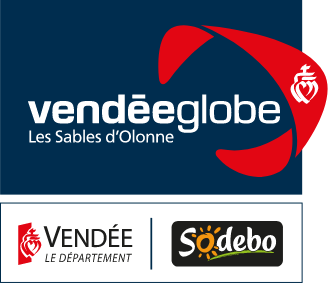

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timezone, timedelta
import requests
from bs4 import BeautifulSoup
import re
import ipyleaflet
from ipyleaflet import Map, Polyline, LayersControl, basemaps, basemap_to_tiles, FullScreenControl, SearchControl, Marker,Icon, Circle

# Acquisition et préparation des données

### Informations relatives aux données dynamiques de la course (classement, positions, vitesses...)
Les fonctions suivantes permettent la collecte des données de classements, vitesses, positions, etc. des bateaux. Ces dernières sont publiées plusieurs fois par jour dans des fichiers Excel qui sont téléchargeables sur le site internet du Vendée Globe : 
- get_results(): la fonction "centrale" qui appelle les autres, qui boucle pour traiter tous les fichiers Excel de classement
- get_results_Excel_names() : elle "scrappe" la page internet des classements pour obtenir les dates et heures de classements disponibles
- prepare_result_data(df): elle extrait les données d'un fichier Excel, les convertit et les retourne dans un DataFrame pandas
- convert_latlon_ddd_dd() : elle convertit les longitudes et latitudes au format degré décimal (pour la carte)


In [2]:
# convert latitude or longitude from degree, minute, second format to degre decimal format
def convert_latlon_ddd_dd(latlon):
    temp = re.split('[^\d\w.]+', latlon)
    dd = float(temp[0]) + float(temp[1])/60
    if temp[2] in ('S','W'): 
        dd *= -1
    return dd

# prepare data of the skipper results (from Excel files) 
# the results are extracted 
def prepare_result_data(df):
    DISTANCE_VENDEE_GLOBE = 24295.80078125
    df = df.dropna()
    df['Sail'] = df['Nat-Sail'].str.split('\n').apply(lambda x : x[-1])
    df['Rank'] = df['Rank'].astype('int32')
    df[['Skipper','Crew']] = df['Skipper-Crew'].str.split('\n', expand=True)
    df['Skipper_Key'] = df['Skipper'].apply(lambda x : x[:3]+x[-3:])
    df['Hour_FR'] = df['Hour_FR'].str.rstrip('FR\n')
    for col in ['Cap_30min', 'Cap_lastreport', 'Cap_24h']:
        df[col] = df[col].str.rstrip('°').astype('int32')
    for col in ['Vitesse_30min', 'Vitesse_lastreport', 'Vitesse_24h', 'VMG_30min', 'VMG_lastreport', 'VMG_24h']:
        df[col] = df[col].str.rstrip(' kts').astype('float32')
    for col in ['Distance_30min', 'Distance_lastreport', 'Distance_24h', 'DTF', 'DTL']:
        df[col] = df[col].str.rstrip(' nm').astype('float32')
    df[['Latitude','Longitude']] = df[['Latitude','Longitude']].applymap(convert_latlon_ddd_dd)
    
    df = df[['Date', 'Rank', 'Sail', 'Skipper', 'Skipper_Key', 'Crew', 'Skipper-Crew', 'Hour_FR', 'Latitude', 'Longitude',
        'Cap_30min', 'Vitesse_30min', 'VMG_30min', 'Distance_30min',
        'Cap_lastreport', 'Vitesse_lastreport', 'VMG_lastreport',
        'Distance_lastreport', 'Cap_24h', 'Vitesse_24h', 'VMG_24h',
        'Distance_24h', 'DTF', 'DTL']]

    return df

# Srap web page to get Excel filenames of the skipper results
def get_results_Excel_names():
    Excel_names_list = []
    url = 'https://www.vendeeglobe.org/fr/classement'
    r = requests.get(url)
    soup = BeautifulSoup(r.content)
    select = soup.find('select', {'class':'form__input m--select onsubmit-rank'})
    for option in select.find_all('option'):
        if (len(option['value'])>0) & (option['value']!='20201108_120200'):
            Excel_names_list.append(option['value'])
       
    return sorted(Excel_names_list)


# Get skippers results from Excel files
def get_results():
    
    result = pd.DataFrame()
    for Excel_name in get_results_Excel_names():
        date_donnees = datetime.datetime.strptime(Excel_name,'%Y%m%d_%H%M%S') 
        filename = 'vendeeglobe_' + Excel_name + '.xlsx'
        try:
            df = pd.read_excel('https://www.vendeeglobe.org/download-race-data/' + filename, 
                               header=None, skiprows=5,
                               names = ['Rank','Nat-Sail', 'Skipper-Crew', 'Hour_FR', 
                                         'Latitude', 'Longitude',
                                         'Cap_30min', 'Vitesse_30min', 'VMG_30min', 'Distance_30min',
                                         'Cap_lastreport', 'Vitesse_lastreport', 'VMG_lastreport', 'Distance_lastreport', 
                                         'Cap_24h', 'Vitesse_24h', 'VMG_24h', 'Distance_24h', 
                                         'DTF', 'DTL'])

            df = df.dropna()
            df['Date'] = date_donnees

            df = prepare_result_data(df)

            if (result.size == 0):
                result = df
            else:
                result = result.append(df, ignore_index=False)
            #print(result.shape)
        except Exception as ex:
            pass
    return result

### Informations techniques relatives aux bateaux
La fonction ci-dessous permet de "scrapper" un page web pour obtenir les informations techniques relatifs aux bateaux (présence d'un foil par exemple). Elle traite les données, les formatte et retourne un DataFrame. La principale difficulté pour réconcilier les données de classement ci-dessus et les informations techniques des bateaux réside dans la qualité des données. Les identifiants comme le nom du skipper ou du bateau ne sont pas orthographiés de la même manière. Par exemple, la navigatrice Davies est appelée soit Sam Davies soit Samantha Davies. Pour relier les deux jeux de données, j'ai créé une clef 'Skipper_Key' qui consiste en les 3 premières lettre du bateau et les 3 dernières du skipper.

In [3]:
# get boat details from web page
def get_boat_technical_details():
    url = 'https://www.vendeeglobe.org/fr/glossaire'
    r = requests.get(url)
    soup = BeautifulSoup(r.content)
    bateaux = {}

    for div in soup.find_all('div', {'class':'sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6'}):
        bateau = {}
        for div2 in div.find_all('div', {'class':'boats-list__infos'}):
            bateau['Crew'] = div2.find('h3', {'class':'boats-list__boat-name'}).text
            bateau['Skipper'] = div2.find('span', {'class':'boats-list__skipper-name'}).text.title()
            bateau['Skipper_Key'] = bateau['Skipper'][:3] + bateau['Skipper'][-3:]
        ul = div.find('ul', {'class':'boats-list__popup-specs-list'})
        for li in ul.find_all('li'):
            if li.text.startswith('Numéro de voile : '):
                bateau['Numero de voile'] = li.text.lstrip('Numéro de voile : ')
            elif li.text.startswith('Longueur : '):
                bateau['Longueur'] = li.text.lstrip('Longueur : ').rstrip(' m').replace(',','.')
            elif li.text.startswith('Largeur : '):
                bateau['Largeur'] = li.text.lstrip('Largeur : ').rstrip(' m').replace(',','.')
            elif li.text.startswith('Tirant d\'eau : '):
                bateau['Tirant'] = li.text.lstrip('Tirant d\'eau : ').rstrip(' m').replace(',','.')
            elif li.text.startswith('Déplacement (poids) : '):
                bateau['Deplacement'] = li.text.lstrip(
                    'Déplacement (poids) : ').rstrip(' t').rstrip(' tonnes').replace(',','.')
            elif li.text.startswith('Nombre de dérives : '):
                if 'foil' in li.text.lstrip('Nombre de dérives : '):
                    bateau['Foil'] = 1
                else:
                    bateau['Foil'] = 0
                bateau['Derives'] = li.text.lstrip('Nombre de dérives : ')
            elif li.text.startswith('Hauteur mât : '):
                bateau['Mat'] = li.text.lstrip('Hauteur mât : ').rstrip(' m').replace(',','.')
            elif li.text.startswith('Voile quille : '):
                bateau['Voile quille'] = li.text.lstrip('Voile quille : ')
            elif li.text.startswith('Surface de voiles au près : '):
                bateau['Surface voile pres'] = li.text.lstrip('Surface de voiles au près : ').rstrip(' m2').rstrip(' m²')
            elif li.text.startswith('Surface de voiles au portant : '):
                bateau['Surface voiles portant'] = li.text.lstrip('Surface de voiles au portant : ').rstrip(' m2').rstrip(' m²')

        bateaux[bateau['Skipper']] = bateau

    df = pd.DataFrame().from_dict(bateaux).T
    for col in ['Longueur','Largeur','Tirant','Deplacement','Foil','Mat','Surface voile pres','Surface voiles portant']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

### Informations techniques relatives aux skippers
Les fonctions ci-dessous permettent de "scrapper" une page web les urls des pages de description des skippers. Ensuite, chaque page est "parsée" pou obtenir des informations techniques relatives aux skippers (âge, nombre de participations aux courses Vendée Globe, nombre de titres gagnés). 

In [4]:
# Scrap skipper details (ex: âge, nb participations, palmarès)
def get_skipper_details(url):
    skipper = {}
    #url = 'https://www.vendeeglobe.org/fr/skippers/93/fabrice-amedeo'
    r = requests.get(url)
    soup = BeautifulSoup(r.content)

    # nom
    h1 = soup.find('h1', {'class':'skipper__section-title'})
    span = h1.find('span', {'class':'skipper__section-subtitle'})
    skipper['Crew'] = span.text
    skipper['Skipper'] = h1.text.replace(skipper['Crew'],'').rstrip().title()

    # age
    div = soup.find('div', {'class':'skipper-datalist'})
    for span in div.find_all('span',{'class':'skipper-datalist__value__text'}):
        if span.text.endswith('ans'):
            skipper['Age'] = span.text.split()[0]

    # participation
    span = soup.find('span', {'class':'skipper-participation__number'})
    skipper['Participation'] = span.find('span').text

    # palmarès
    skipper['Palmarès'] = len(soup.find_all('div', {'class':'prizes-slider__slide'}))

    return skipper

# Scrap all skipper details
def get_skippers_details():
    url = 'https://www.vendeeglobe.org/fr/organisation'
    r = requests.get(url)
    soup = BeautifulSoup(r.content)
    skippers = {}
    li = soup.find('li', {'class':'menu__item m--skippers menu-skippers'})
    for a in li.find_all('a', {'class':'menu-skippers__item'}):
        url_skipper = 'https://www.vendeeglobe.org' + a['href']
        skipper = get_skipper_details(url_skipper)
        skippers[skipper['Skipper']] = skipper
    df = pd.DataFrame(skippers).T
    for col in ['Age','Participation','Palmarès']:
        df[col] = pd.to_numeric(df[col])
    return df

### Chargement des données dynamiques (classements, positions, vitesses...) et statiques (détails sur les bateaux et les skippers)

In [5]:
# Chargement des données Résultats, Bateaux et Skippers
df_resultats = get_results()
df_boats_details = get_boat_technical_details()
df_skippers_details = get_skippers_details()

### Opérations de "merge" des Dataframes et calcul des distances cumulées

In [6]:
# Opérations de merge entre les DataFrames

# Dernier classement
df_derniers_resultats = df_resultats[df_resultats['Date'] == df_resultats['Date'].max()]

# Boats and skipper details
df_boats_skippers_details = pd.merge(df_boats_details,df_skippers_details,on='Skipper',how='inner')

# Big DataFrame with results linked to boats and skippers details
df_results_boats_skippers = pd.merge(df_resultats,df_boats_skippers_details,on='Skipper_Key',how='left')

# Results and boats details
df_results_merge = pd.merge(df_resultats,df_boats_details,on='Skipper_Key',how='left')
df_derniers_resultats_boats = pd.merge(df_derniers_resultats,df_boats_details,on='Skipper_Key',how='left')
df_derniers_resultats_boats_skippers = pd.merge(df_derniers_resultats,df_boats_skippers_details,on='Skipper_Key',how='left')

# Cumulated distances computation 
# Distances totales par skipper
df_distances_totales = df_resultats.loc[df_resultats['Date'].dt.hour == 14].groupby('Skipper').agg({'Distance_24h':'sum'})
df_distances_quotidiennes = df_resultats.loc[df_resultats['Date'].dt.hour == 14].groupby(
    ['Skipper','Date']).agg(
    {'Distance_24h':'sum'}).unstack()
df_distances_quotidiennes_cumulees = df_distances_quotidiennes.cumsum(axis=1)
df_results_merge_distances_24h = pd.merge(
    df_results_merge,df_distances_quotidiennes_cumulees.stack(),
    left_on=['Skipper_x','Date'],right_on=['Skipper','Date'],how='inner')
df_results_merge_distances_24h['Distance_24h_z'] = (
    round(df_results_merge_distances_24h['Distance_24h_y'],0) // 250) *250
# Interpolation des distances
df_results_merge_distances_24h['Distance'] = df_results_merge_distances_24h['Distance_24h_y'].interpolate()

### Récapitulatif des données chargées

In [7]:
print('Du site internet du Véndée Globe :')
print('- ' + str(df_resultats['Date'].nunique()) + ' fichiers Excel ont été traités')
print('- ' + str(df_resultats.shape[0]) + ' lignes de résultats ont été extraites des fichiers Excel')
print('- ' + str(df_boats_details['Skipper'].nunique()) + ' bateaux ont eu leurs caractéristiques extraites')
print('- ' + str(df_skippers_details['Skipper'].nunique()) + ' skippers ont eu leurs caractéristiques extraites')

Du site internet du Véndée Globe :
- 135 fichiers Excel ont été traités
- 4366 lignes de résultats ont été extraites des fichiers Excel
- 33 bateaux ont eu leurs caractéristiques extraites
- 33 skippers ont eu leurs caractéristiques extraites


## Visualisation des distances parcourues et à parcourir

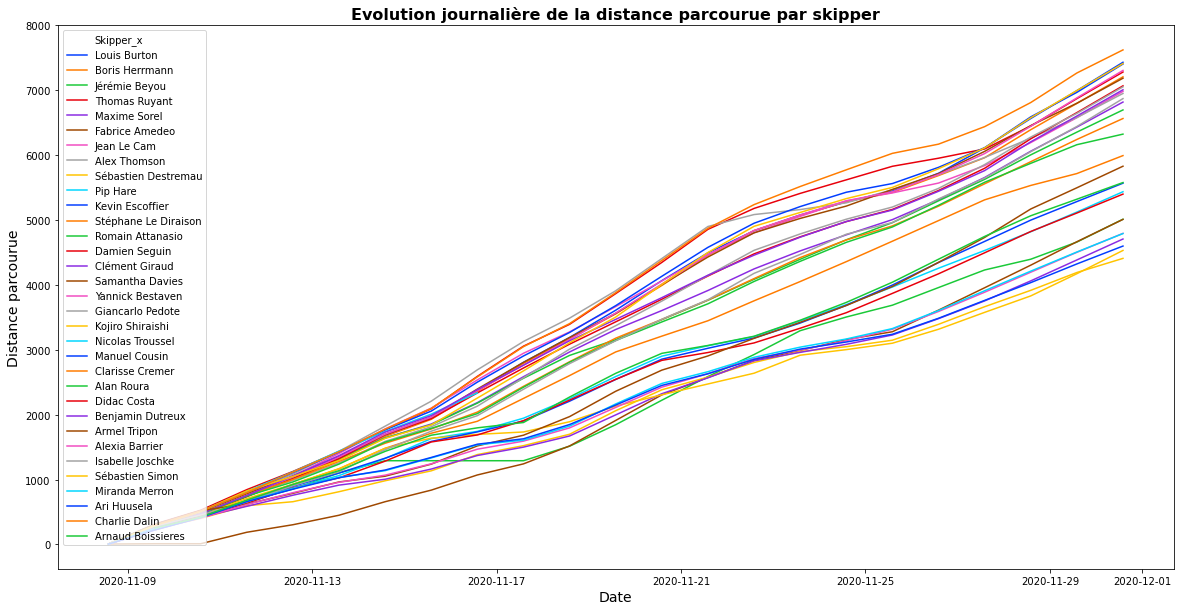

In [8]:
# Evolution journalière de la distance parcourue par skipper
plt.figure(figsize=(20,10))
sns.lineplot(data=df_results_merge_distances_24h[['Date','Skipper_x','Distance_24h_y']],
            x='Date',y='Distance_24h_y', hue='Skipper_x',palette=sns.color_palette("bright",33))
plt.xlabel('Date', fontsize=14)
plt.ylabel('Distance parcourue', fontsize=14)
plt.title('Evolution journalière de la distance parcourue par skipper', fontweight="bold", fontsize=16)
plt.legend(loc='upper left')
plt.show()

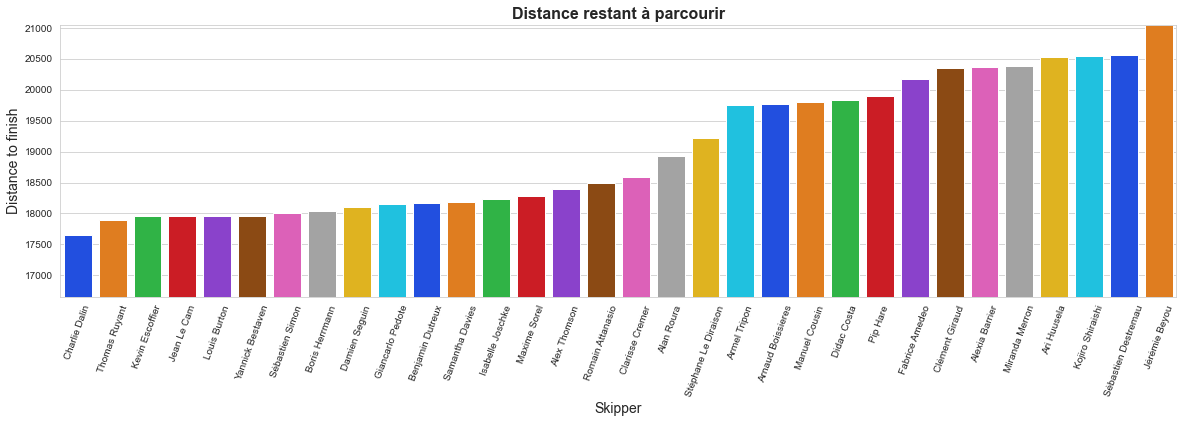

In [9]:
# Visualisation de la distance restante à parcourir par voilier
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
sns.barplot(x=df_derniers_resultats['Skipper'], y=df_derniers_resultats['DTF'], palette=sns.color_palette("bright",33))
plt.ylim(max(0,df_derniers_resultats['DTF'].min()-1000),df_derniers_resultats['DTF'].max())
plt.xticks(rotation=70)
plt.xlabel('Skipper', fontsize=14)
plt.ylabel('Distance to finish', fontsize=14)
plt.title('Distance restant à parcourir', fontweight="bold", fontsize=16)
plt.show()

## Visualisation de la route des voiliers

In [10]:
# Trajectoires des voiliers
def set_skipper_color():
    skipper_color = {}
    palette = sns.color_palette("bright",40).as_hex()
    i = 0
    for skipper in df_resultats['Skipper'].unique():
        skipper_color[skipper] = palette[i]
        i += 1
    return skipper_color
skipper_color = set_skipper_color()

trajectoires = []
for skipper in df_derniers_resultats['Skipper'].append(
    pd.Series(df_resultats['Skipper'].unique())).drop_duplicates():
    rank = df_derniers_resultats.loc[df_derniers_resultats['Skipper'] == skipper,'Rank']
    if len(rank.values) == 1:
        rank = rank.values[0]
    else:
        rank = 'Retired'

    lines = Polyline(
        name= str(rank) + ' - ' + skipper,
        locations=df_resultats.loc[df_resultats['Skipper'] == skipper,['Latitude','Longitude']].values.tolist(),
        color=skipper_color[skipper] ,
        fill=False,
        weight=1)
    trajectoires.append(lines)

m = Map(basemap=basemaps.Esri.WorldTopoMap, center = (df_derniers_resultats['Latitude'].mean(), 
                                                      df_derniers_resultats['Longitude'].mean()), zoom =3)
for trajectoire in trajectoires:
    m.add_layer(trajectoire)
control = LayersControl(position='topright')
m.add_control(control)

m.add_control(FullScreenControl())
m.save('parcours_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '.html', title='Parcours')
m

Map(center=[-34.837947916666664, -11.10211458333333], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Visualisation de l'évolution des classements sur les 5 derniers jours

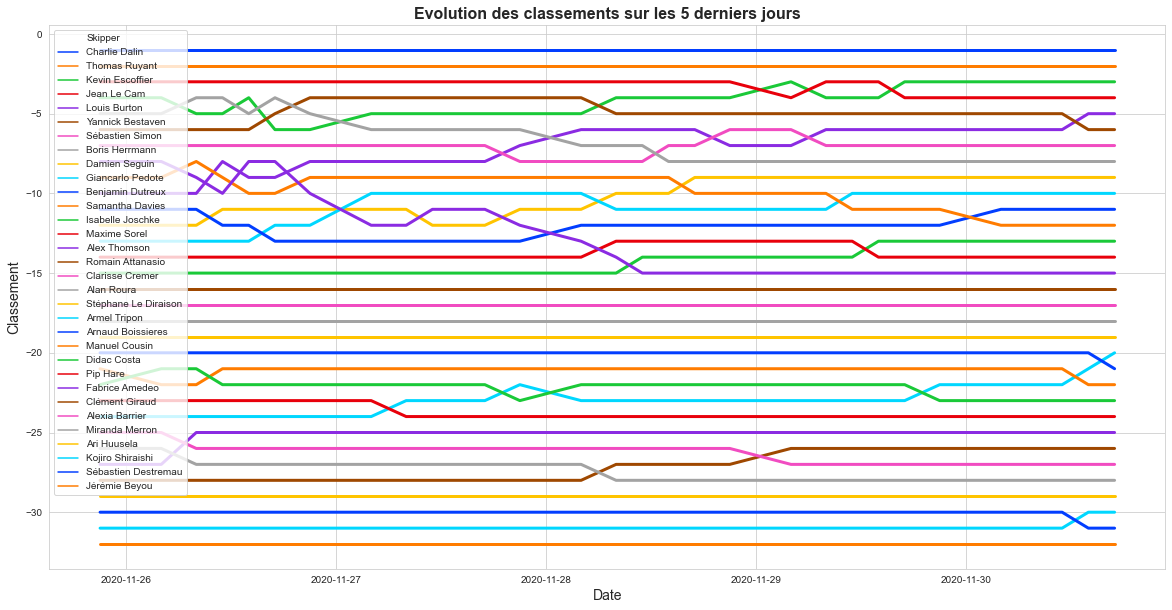

In [11]:
plt.figure(figsize=(20,10))

def get_rank_skipper(row):
    return str(row['Rank']) + ' - ' + row['Skipper']

df_rank = df_resultats.loc[df_resultats['Date']>
                                   df_resultats['Date'].max()-datetime.timedelta(days=5),
                                   ['Date','Skipper','Rank']].sort_values(['Date','Rank'], ascending=[False,True])
df_rank['Rank'] = -df_rank['Rank']
sns.lineplot(data=df_rank,
             x='Date',
             y='Rank',
             hue='Skipper',
             palette=sns.color_palette("bright",len(df_rank['Skipper'].unique())), 
             linewidth=3, dashes=False)
plt.title('Evolution des classements sur les 5 derniers jours', fontsize=16, fontweight="bold")
plt.xlabel('Date', fontsize=14)
plt.ylabel('Classement', fontsize=14)
plt.legend(loc='upper left')
plt.show()

## Analyse de la corrélation entre le classement (rang) et la vitesse utile (VMG) des voiliers

In [12]:
# Relation entre le rang et les VMG et vitesses moyennes
df_corr_rank_VMG = df_resultats.groupby(['Skipper']).agg(
    {'Rank':'last','VMG_24h':'mean','VMG_24h':'var','Vitesse_24h':'mean','Vitesse_24h':'var'}
    ).sort_values('VMG_24h',ascending=False)
# Matrice de correlation entre le rang et les VMG et vitesses moyennes
df_corr_rank_VMG.corr()

,Rank,VMG_24h,Vitesse_24h
Rank,1.000000,-0.425509,-0.403004
VMG_24h,-0.425509,1.000000,0.878609
Vitesse_24h,-0.403004,0.878609,1.000000


In [13]:
df_corr_rank_VMG

,Rank,VMG_24h,Vitesse_24h
Skipper,,,
Jérémie Beyou,32,42.315144,22.744608
Alex Thomson,15,31.195166,26.154823
Thomas Ruyant,2,28.819181,25.811972
Louis Burton,5,26.776646,18.970314
Sébastien Simon,7,25.404856,21.706636
Kevin Escoffier,3,23.900887,18.410717
Boris Herrmann,8,22.106447,17.606514
Charlie Dalin,1,21.517506,19.364046
Yannick Bestaven,6,21.343975,17.477030


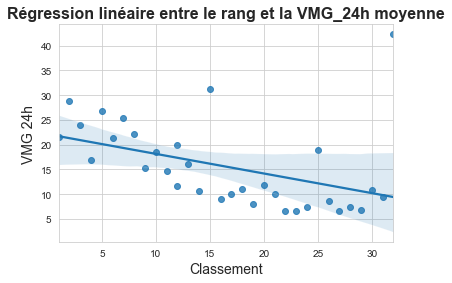

In [14]:
plt.figure()
sns.regplot(x=df_corr_rank_VMG['Rank'],y=df_corr_rank_VMG['VMG_24h'])
plt.title('Régression linéaire entre le rang et la VMG_24h moyenne', fontsize=16, fontweight="bold")
plt.xlabel('Classement', fontsize=14)
plt.ylabel('VMG 24h', fontsize=14)
plt.show()

D'après le tableau de corrélation, le rang et la VMG (ainsi que la vitesse) sont corrélées négativement. Cependant, le coefficient de corrélation est faible (-0.42 au 30/11/2020). Ceci est dû au fait que le rang dépend de la distance parcourue et non purement de la vitesse et de la VMG (qui prend en compte le cap). En effet, les skippers (ex : Béyou, Thompson, Amédéo) qui ont été forcés de s'arrêter pour réparer peuvent avoir des VMG importantes avec un rang faible. Par exemple, au 30/11, Beyou a une VMG 24h moyenne de 42.4 alors qu'il est 32ème. De même pour Thompson qui est 15ème avec une VMH 24h moyenne de 31.3.

## Analyse de l'impact de la présence d'un foil sur le classement et la vitesse des voiliers

Les foilers sont en moyenne plus rapides que les dériveurs classiques (10,2 noeuds contre 9.2 respectivement au 28/11/2020), ce qui paraît logique. 

Cependant, la différence en moyenne n'est pas fragrante. Si on regarde la distribution des VMG des foilers, elle est plus étalée, en particulier aux extrêmes. En effet, les extrêmes montrent que les foilers vont beaucoup plus vite d'une part, mais qu'ils sont plus souvent "arrêtés" pour casse ou réparation (ex : Amadéo, Beyou, Trousselle, Thompson, Ruyant). Ceci est dû au fait que ces bâteaux sont plus récents et donc plus expérimentaux. Par ailleurs, comme le montre le graphique ci-dessous de l'évolution des VMG des foilers vs dériveurs, on constate qu'au début de la course, les foilers n'étaient pas avantagés par rapport aux dériveurs, en raison des conditions météorologiques.

Par conséquent, on observe les foilers aux premières places mais aussi pour une petite partie aux dernières places (ex : Béyou et Shiraishi au 28/11/2020).

In [15]:
# VMG et Vitesses moyennes en fonction de la présence d'un foil 
# (Foil=1 pour un foiler / Foil=0 pour un dériveur classiqe) 
df_results_merge.groupby(['Foil']).agg(
    {'Rank':'last','VMG_24h':'mean','Vitesse_24h':'mean'}).sort_values(['Foil','VMG_24h'],ascending=[False,False])

,Rank,VMG_24h,Vitesse_24h
Foil,,,
1,32,10.527706,12.009410
0,31,9.429577,10.581958


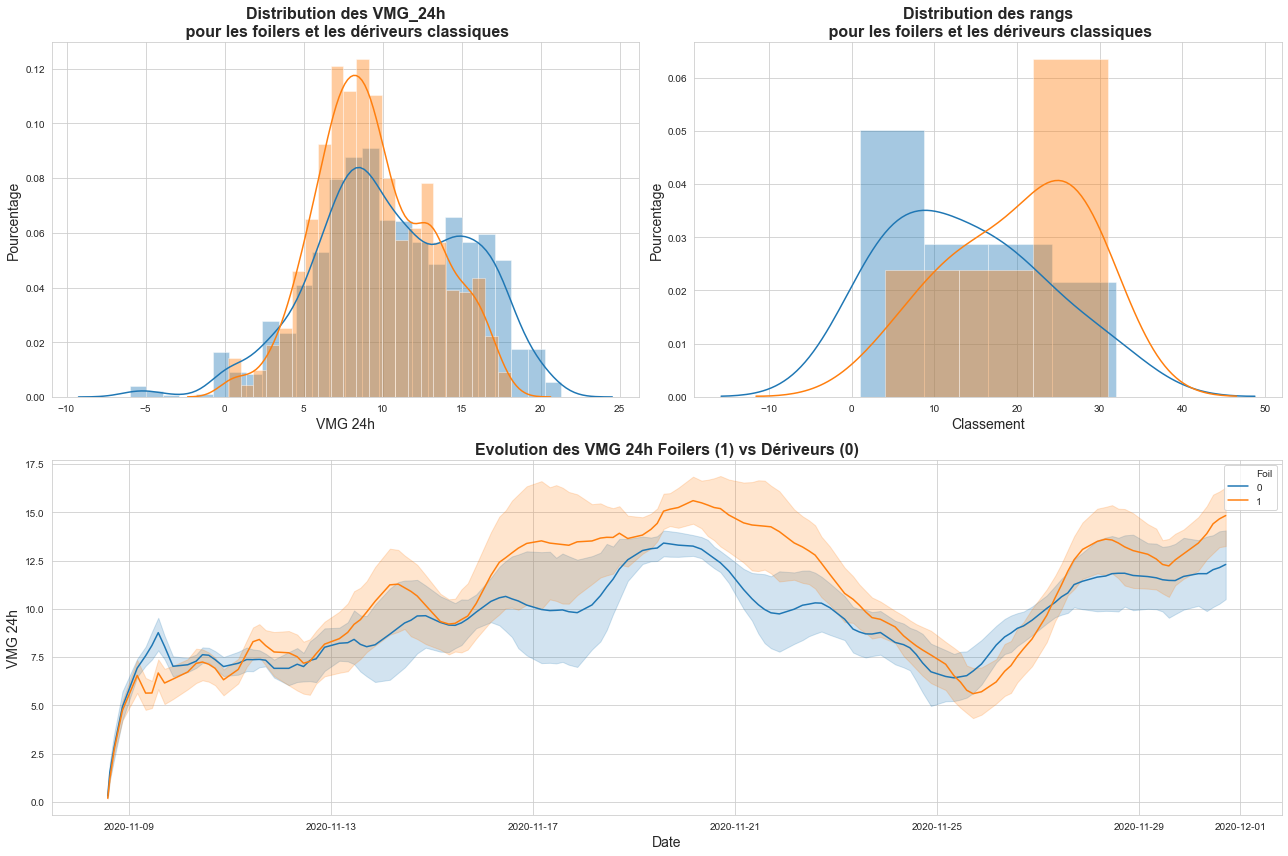

In [16]:
plt.figure(figsize=(18,12))
plt.subplot(221)
sns.distplot(df_results_merge.loc[df_results_merge['Foil']==1,'VMG_24h'], label='Foilers')
sns.distplot(df_results_merge.loc[df_results_merge['Foil']==0,'VMG_24h'], label='Dériveurs classiques')
plt.title('Distribution des VMG_24h\n pour les foilers et les dériveurs classiques', fontsize=16, fontweight="bold")
plt.xlabel('VMG 24h', fontsize=14)
plt.ylabel('Pourcentage', fontsize=14)

plt.subplot(222)
sns.distplot(df_derniers_resultats_boats.loc[df_derniers_resultats_boats['Foil']==1,'Rank'], label='Foilers', hist=True)
sns.distplot(df_derniers_resultats_boats.loc[df_derniers_resultats_boats['Foil']==0,'Rank'], label='Dériveurs classiques', hist=True)
plt.title('Distribution des rangs\n pour les foilers et les dériveurs classiques', fontsize=16, fontweight="bold")
plt.xlabel('Classement', fontsize=14)
plt.ylabel('Pourcentage', fontsize=14)

plt.subplot(212)
sns.lineplot(x="Date", y="VMG_24h",
             hue="Foil", 
             data=df_results_merge)
plt.title('Evolution des VMG 24h Foilers (1) vs Dériveurs (0)', fontsize=16, fontweight="bold")
plt.xlabel('Date', fontsize=14)
plt.ylabel('VMG 24h', fontsize=14)

plt.legend()
plt.tight_layout()

plt.show()

## Application d'un algorithme de clustering (Kmeans) pour regrouper les bateaux en 6 groupes dépendant de leur dernière position

Les bateaux sont regroupés par position géographique à l'aide d'un algorithme de clustering non supervisé, Kmeans. Les groupes sont déterminés en fonction des distances entre bateaux. On recontitue ainsi les groupes de tête, de chasse et queue de poleton.

In [17]:
# Clustering des dernières des voiliers en 6 groupes
# sklearn.cluster.KMeans
import sklearn as sk
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=6)
kmeans.fit(df_derniers_resultats[['Latitude','Longitude']])
kmeans.labels_   
    
m = Map(basemap=basemaps.Esri.WorldTopoMap, center = (df_derniers_resultats['Latitude'].mean(), 
                                                      df_derniers_resultats['Longitude'].mean()), zoom = 3 )
i=0
palette = sns.color_palette("bright",6).as_hex()
for result in df_derniers_resultats.values.tolist():
    position = result[8:10]
    rank = result[1]
    skipper = result[3]
    cap = result[10] 
    circle = Circle(location=position, radius=50000, color=palette[kmeans.labels_[i]],
                    fill_color=palette[kmeans.labels_[i]], name=str(rank) + ' - ' + skipper)
    i += 1
    m.add_layer(circle);
    
control = LayersControl(position='topright')
m.add_control(control)
m.add_control(FullScreenControl())
m.save('dernières_positions_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '.html',title='Positions des bateaux par groupes')
m

Map(center=[-34.837947916666664, -11.10211458333333], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Application d'un arbre de décision pour déterminer si un bateau possède un foil

On va essayer de déterminer de déterminer si un bateau possède un foil à l'aide d'un arbre de décision (DecisionTreeClassifier de scikit-learn). Pour cela, on va tester plusieurs combinaisons de features et vérifier que le taux de bonnes prédictions (accuracy) est fort (proche de 1.0). 

Au niveau méthodologique, on contruit une matrice X composée des features, un vecteur Y composé du résultat, soit la présence d'un foil. On sépare ces matrices en jeux d'entraînement (80%) et de test (20%). On entraîne l'arbre de décision sur le jeu d'entraînement, on prédit la présence d'un foil sur les données de test et on mesure la "précision" de la prédiction.

A la suite de la combinaison de plusieurs features, la précision maximale obtenue est de 82.7% au 30/11. On observe que les features les plus importantes sont le palmarès (le nombre de courses gagnées) (seuils à 5.5 puis 1.5 courses gagnées) et l'âge (seuil à 49.5 ans). Ce sont des features qui portent uniquement sur le skipper. Cela traduirait l'appétence d'un skipper à utiliser un foiler en fonction de son expérience.

In [18]:
df_X = df_results_boats_skippers[['VMG_24h','Age','Participation','Palmarès']]
df_Y = df_results_boats_skippers['Foil']
from sklearn import model_selection
df_X_train, df_X_test, df_Y_train, df_Y_test = model_selection.train_test_split(df_X, df_Y, train_size=0.8,test_size=0.2)

[Text(167.4, 181.2, 'X[3] <= 5.5\ngini = 0.491\nsamples = 3492\nvalue = [1508, 1984]'),
 Text(83.7, 108.72, 'X[3] <= 1.5\ngini = 0.24\nsamples = 762\nvalue = [656, 106]'),
 Text(41.85, 36.23999999999998, 'gini = 0.0\nsamples = 106\nvalue = [0, 106]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.0\nsamples = 656\nvalue = [656, 0]'),
 Text(251.10000000000002, 108.72, 'X[1] <= 49.5\ngini = 0.429\nsamples = 2730\nvalue = [852, 1878]'),
 Text(209.25, 36.23999999999998, 'gini = 0.354\nsamples = 2291\nvalue = [526, 1765]'),
 Text(292.95, 36.23999999999998, 'gini = 0.382\nsamples = 439\nvalue = [326, 113]')]

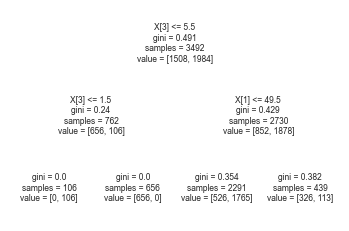

In [19]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree = decision_tree.fit(df_X_train, df_Y_train)
tree.plot_tree(decision_tree) 

In [20]:
predictions = decision_tree.predict(df_X_test)
#Accuracy
print('La précision du modèle est de : ' + str(sum(df_Y_test == predictions) / len(predictions)))

La précision du modèle est de : 0.8043478260869565


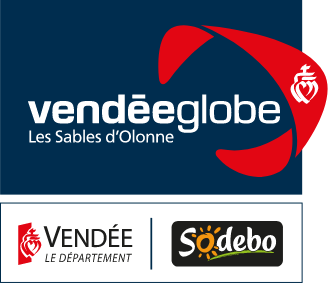